In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install fastai

In [ ]:
from fastai.vision import *

In [ ]:
#build fastai dataset loader
np.random.seed(42)
path = Path('/content/drive/MyDrive/Covid_tvt/')
data = ImageDataBunch.from_folder(path, size=224, num_workers=4).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data.classes

['COVID', 'Normal']

In [ ]:
#setting up fastai resnet model
from fastai.metrics import error_rate 
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [ ]:
from fastai.callbacks import *
early_stop = EarlyStoppingCallback(learn, patience=20)
save_best_model = SaveModelCallback(learn, name='best_resnet34')

In [ ]:
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(30, callbacks=[early_stop, save_best_model])

epoch,train_loss,valid_loss,error_rate,time
0,0.131865,0.116550,0.041532,01:31
1,0.121641,0.107894,0.037236,01:31
2,0.096109,0.095614,0.033298,01:30
3,0.079674,0.084060,0.026137,01:31
4,0.066005,0.088367,0.028643,01:31
5,0.057598,0.084017,0.024705,01:29
6,0.053382,0.069848,0.017902,01:30
7,0.045749,0.064383,0.020408,01:32
8,0.029914,0.064993,0.017544,01:32
9,0.028474,0.062340,0.015038,01:30


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Better model found at epoch 0 with valid_loss value: 0.11654973030090332.
Better model found at epoch 1 with valid_loss value: 0.10789385437965393.
Better model found at epoch 2 with valid_loss value: 0.09561417251825333.
Better model found at epoch 3 with valid_loss value: 0.08406049758195877.
Better model found at epoch 5 with valid_loss value: 0.08401715755462646.
Better model found at epoch 6 with valid_loss value: 0.0698482021689415.
Better model found at epoch 7 with valid_loss value: 0.06438314914703369.
Better model found at epoch 9 with valid_loss value: 0.06234046816825867.
Better model found at epoch 10 with valid_loss value: 0.05514680966734886.
Better model found at epoch 14 with valid_loss value: 0.04490217566490173.
Better model found at epoch 17 with valid_loss value: 0.044330328702926636.


In [ ]:
learn.load('best_resnet34')

Learner(data=ImageDataBunch;

Train: LabelList (11168 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
COVID,COVID,COVID,COVID,COVID
Path: /content/drive/MyDrive/Covid_tvt;

Valid: LabelList (2793 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
COVID,COVID,COVID,COVID,COVID
Path: /content/drive/MyDrive/Covid_tvt;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps

In [ ]:
learn.unfreeze()

In [ ]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    min_loss_index = np.argmin(losses)
    
    
    #loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #return the learning rate that produces the minimum loss divide by 10   
    return lrs[min_loss_index] / 10

In [ ]:
optimal_lr = find_appropriate_lr(learn)

epoch,train_loss,valid_loss,error_rate,time


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [ ]:
learn.fit_one_cycle(30, max_lr=slice(optimal_lr/10, optimal_lr), callbacks=[early_stop, save_best_model])

epoch,train_loss,valid_loss,error_rate,time
0,0.004444,0.048562,0.007877,01:35
1,0.003419,0.046179,0.008235,01:37
2,0.005036,0.044219,0.007519,01:39
3,0.006565,0.048413,0.007877,01:38
4,0.003616,0.047798,0.008235,01:37
5,0.002773,0.046685,0.007161,01:37
6,0.004921,0.044904,0.007519,01:38
7,0.005502,0.048235,0.007519,01:40
8,0.003450,0.044962,0.007519,01:40
9,0.009829,0.050726,0.008593,01:39


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Better model found at epoch 0 with valid_loss value: 0.048561837524175644.
Better model found at epoch 1 with valid_loss value: 0.04617905244231224.
Better model found at epoch 2 with valid_loss value: 0.04421896114945412.
Epoch 23: early stopping


In [ ]:
learn.load('best_resnet34')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


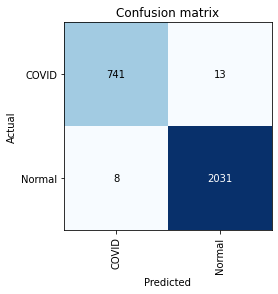

In [ ]:
#plotting confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


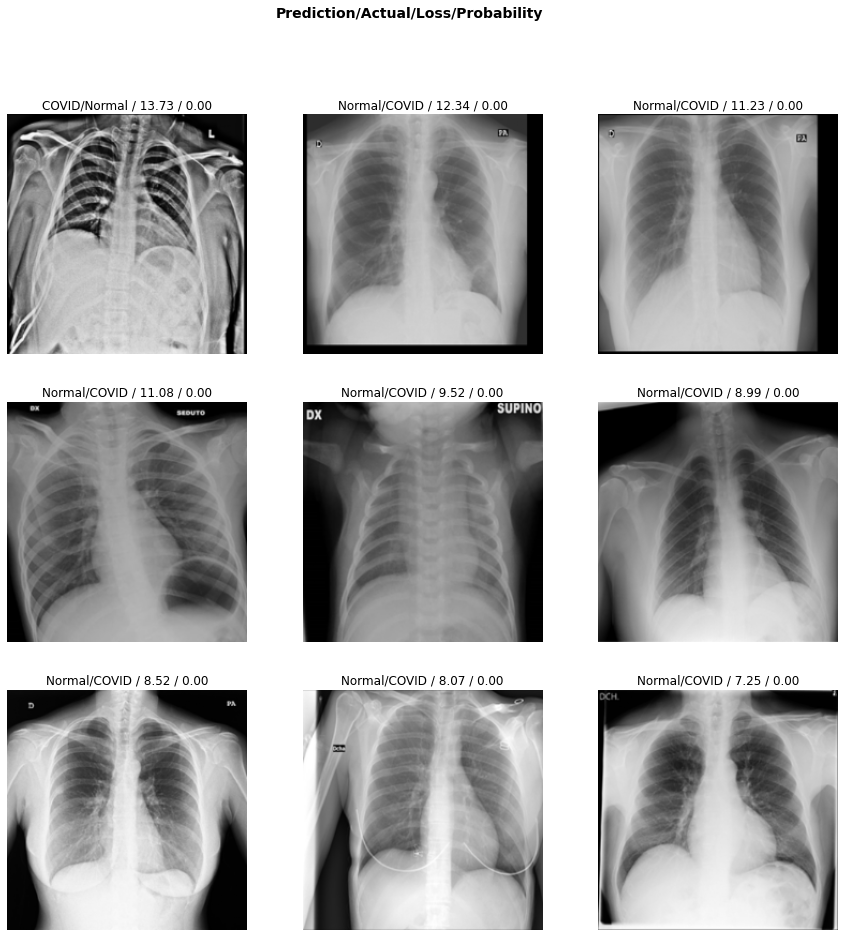

In [ ]:
interp.plot_top_losses(9, figsize=(15,15))

In [ ]:
#run inference on test images
import glob
from IPython.display import Image, display

model = learn.model
model = model.cuda()
for imageName in glob.glob('/content/drive/MyDrive/Covid_tvt/valid/*/*.jpg'):
    print(imageName)
    img = open_image(imageName)
    prediction = learn.predict(img)
    #print(prediction)
    print(prediction[0])
    display(Image(filename=imageName))
    print("\n")